# Exploraty data analyses

Foi desenvolvida uma solução aceitável para o problema abordado. Os passos utilizados durante a construção dessa solução podem ser encontrados logo abaixo:

### Summary

*Os links abaixo não funcionam no GitHub, apenas se o notebook for acessado.*

1. [Imports](#Imports)
2. [Data pre processing](#Data-pre-processing)
    - Accessing the data
    - Feature engineering: format correction, feature creation, sample balancement, null values correction
    - Outliers
    - Distribution analyses
    
    
3. [Data processing](#Data-processing)
    - Descriptive statistics analysis for each class (Exited/Not exited)
    - Correlation analyses
    
    
4. [Modeling](#Modeling)
5. [Evaluation](#Evaluation)
    - Model Evaluation about the used data set
    - Estimated model evaluation about real world data
    
    
5. [Deploy](#Deploy): just storing the results - the real deploy will be maked in another document

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from math import sqrt
from scipy.stats import kstest, shapiro 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

import pickle

## Data pre processing

### Download the data set

In [2]:
# !kaggle datasets files "shubh0799/churn-modelling"
# !kaggle datasets download "shubh0799/churn-modelling"

# !mv ./churn-modelling.zip ../Dataset

/usr/bin/sh: 1: kaggle: not found
/usr/bin/sh: 1: kaggle: not found
mv: cannot stat './churn-modelling.zip': No such file or directory


### Accessing the data

In [3]:
data = pd.read_csv('../Dataset/churn-modelling.zip').drop('RowNumber', axis=1)
data.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
qualitatives = ['CustomerId', 'Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']
quantitatives = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

### Feature engineering

#### Format correction

In [5]:
data = pd.concat([data.drop('Geography', axis=1), pd.get_dummies(data['Geography'], prefix='Geography')], axis=1) 

*Geography* é uma coluna categorica textual. Dessa forma, foi necessário **separar uma coluna para cada valor possível dessa varíavel**. O resultado foi a criação de novas três colunas: 'Geography_France', 'Geography_Germany' e 'Geography_Spain'.

In [6]:
data['Gender_Male'] = data['Gender'].apply(lambda x:1 if x == 'Male' else 0)

Gender também é uma coluna categórica textual com os valores possíveis 'Male' e 'Female'. Os valores textuais 'Male' foram substituidos por 1, enquanto 'Female' por 0. A coluna foi renomeada para Gender_male com intuito de tornar a mudança mais intuitiva.

#### Feature creation

In [7]:
surnames = data['Surname'].values

def surname_freq(surname):
    cont = 0
    
    for name in surnames:
        if name == surname:
            cont += 1
            
    return cont

data['Surname_freq'] = data['Surname'].apply(surname_freq)
data['Has_parent'] = data['Surname_freq'].apply(lambda x:1 if x > 1 else 0)

Como *surnames* é uma característica textual do indivíduo, ela não fornece muita informação a priori. Dessa forma, tal coluna foi processada e duas características novas foram criadas: 
- Surname_freq: frequência que aparece o sobrenome
- Has_parent: se o cliente tem parente na empresa (Surname_freq > 1)

In [8]:
data = data[['CreditScore', 'Gender_Male', 'Age', 'Tenure', 'Balance',
             'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
             'Geography_France', 'Geography_Germany', 'Geography_Spain',
             'Surname_freq', 'Has_parent', 'Exited']]

Ordem das colunas foi apenas reajustada para que *Exited* se mantivésse em último no conjunto.

In [9]:
qualitatives = ['CustomerId', 'Surname', 'Geography_France', 'Geography_Germany',
                'Geography_Spain', 'Gender_Male', 'Gender_Female', 'HasCrCard', 'IsActiveMember', 
                'Has_parent', 'Exited']

quantitatives = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                 'EstimatedSalary', 'Surname_freq']

#### Sample balancement

In [10]:
display(data['Exited'].value_counts(normalize=True).to_frame())

,Exited
0,0.7963
1,0.2037


Como pôde ser visualizado, existem muito mais casos no conjunto de não saída do que de saída, o que pode gerar um modelo tendencioso para casos de não saída. 

Dessa forma, será realizada então uma sub amostragem aleatória dessa amostra (para casos de não saída) para que haja balanceamento entre os possíveis valores. 

In [11]:
np.random.seed(7)

i = data.query('Exited == 0').index
n = len(data.query('Exited == 1').index.to_list()) + 1

i_sampled = np.random.choice(i, n)

Com o procedimento acima, foi feita uma subamostragem a amostra total de valores *Exited* iguais a 0. Abaixo será avaliado se a subamostra representa aceitavelmente a amostra original. Cada coluna da nova amostra será comparada com cada coluna da amostra total através do teste de distribuição amostral KS.

In [12]:
original = data.loc[i]
sampled = data.loc[i_sampled]

for column in original.columns:
    print(kstest(original[column].values, sampled[column].values))

KstestResult(statistic=0.01850295842018107, pvalue=0.6268346939267916)
KstestResult(statistic=0.008734891020133969, pvalue=0.9995686023232194)
KstestResult(statistic=0.014679275358050118, pvalue=0.8693319727498474)
KstestResult(statistic=0.014443272165167236, pvalue=0.8814529409950971)
KstestResult(statistic=0.01571898341901954, pvalue=0.810278847804602)
KstestResult(statistic=0.002671087834226428, pvalue=1.0)
KstestResult(statistic=0.0033549425168933303, pvalue=1.0)
KstestResult(statistic=0.002553086237784986, pvalue=1.0)
KstestResult(statistic=0.01807673542144193, pvalue=0.6557818955543555)
KstestResult(statistic=0.0014988975631530371, pvalue=1.0)
KstestResult(statistic=0.01579606957941027, pvalue=0.8055855007797088)
KstestResult(statistic=0.017294967142563306, pvalue=0.7086826623303911)
KstestResult(statistic=0.014726968953687547, pvalue=0.866821052450195)
KstestResult(statistic=0.00807297292667498, pvalue=0.9999087527600012)
KstestResult(statistic=0.0, pvalue=1.0)


Como o resultado foi aceitável, o conjunto de dados será balanceado usando a amostra original Exited == 1 e a sub amostra Exited == 0.

In [13]:
data = pd.concat([data.query('Exited == 1'), data.loc[i_sampled]], axis=0).sort_index().reset_index(drop=True)

display(data['Exited'].value_counts(normalize=True).to_frame())

,Exited
0,0.500123
1,0.499877


Dessa forma, tem-se um conjunto de dados balanceado 50/50.

#### Null values correction
O conjunto obtido até aqui não apresenta dados nulos.

### Outliers

#### Cases detection

<AxesSubplot:title={'center':'CreditScore'}>

<AxesSubplot:title={'center':'Age'}>

<AxesSubplot:title={'center':'Tenure'}>

<AxesSubplot:title={'center':'Balance'}>

<AxesSubplot:title={'center':'NumOfProducts'}>

<AxesSubplot:title={'center':'EstimatedSalary'}>

<AxesSubplot:title={'center':'Surname_freq'}>

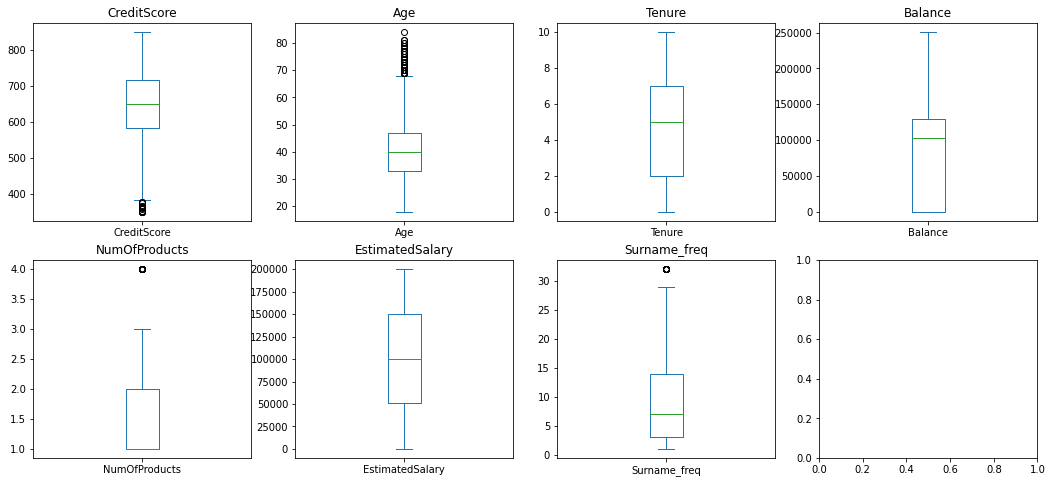

In [14]:
i = 0
j = 0

fig, ax = plt.subplots(2, 4, figsize=(18, 8))

for column in quantitatives:
    ax[i][j].set_title(column)
    display(data[column].plot(kind='box', ax=ax[i][j]))
    j += 1

    if j%4==0:
        j = 0
        i += 1

#### Treatment

In [15]:
def threshold(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)

    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5*IQR
    upper_threshold = Q3 + 1.5*IQR
    
    return lower_threshold, upper_threshold


for column_name in ['NumOfProducts', 'Age', 'Surname_freq', 'CreditScore']:
    lt, ut = threshold(data, column_name)
    data[column_name] = data[column_name].apply(lambda x: lt if x < lt else x)
    data[column_name] = data[column_name].apply(lambda x: ut if x > ut else x)

As anomalias foram tratadas utilizando a substituição de valor baseada em limite superior e inferior, em que:
 - Se determinado valor é maior que o limite superior, então o valor passa a ser o próprio limite superior
 - Se determinado valor é menor que o limite inferior, então o valor passa a ser o próprio limite inferior

<AxesSubplot:title={'center':'CreditScore'}>

<AxesSubplot:title={'center':'Age'}>

<AxesSubplot:title={'center':'Tenure'}>

<AxesSubplot:title={'center':'Balance'}>

<AxesSubplot:title={'center':'NumOfProducts'}>

<AxesSubplot:title={'center':'EstimatedSalary'}>

<AxesSubplot:title={'center':'Surname_freq'}>

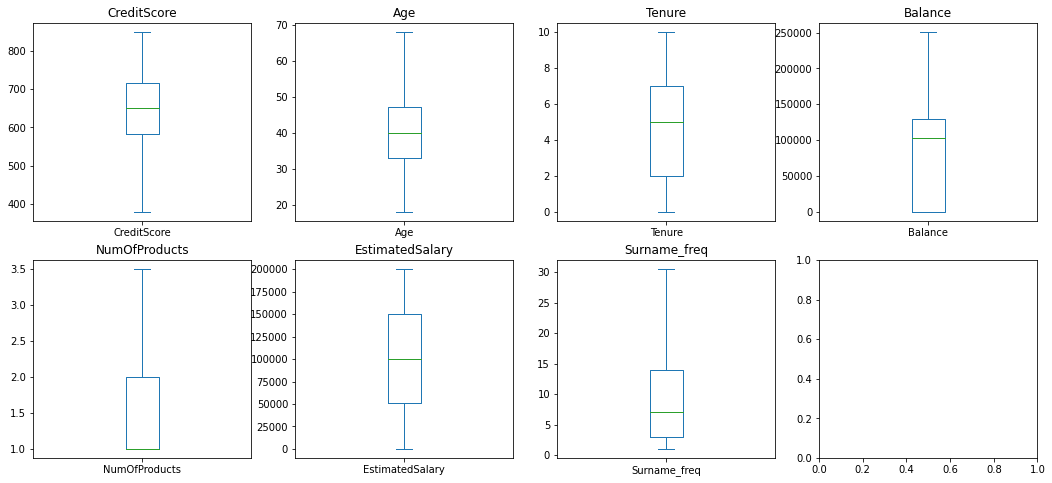

In [16]:
i = 0
j = 0

fig, ax = plt.subplots(2, 4, figsize=(18, 8))

for column in quantitatives:
    ax[i][j].set_title(column)
    display(data[column].plot(kind='box', ax=ax[i][j]))
    j += 1

    if j%4==0:
        j = 0
        i += 1

Como observado, todas as anomalias foram tratadas.

### Distribution analyses

In [17]:
#Identificação de normalidade
for column in quantitatives:
    print(f'\n {column}: p-value = {shapiro(data[column])[1]}')


 CreditScore: p-value = 1.1853103134423781e-12

 Age: p-value = 1.4128842755862998e-23

 Tenure: p-value = 6.564754975526383e-36

 Balance: p-value = 0.0

 NumOfProducts: p-value = 0.0

 EstimatedSalary: p-value = 3.307495112982142e-34

 Surname_freq: p-value = 1.056579042100912e-42


Através do teste de Normalidade Shapiro, pode-se perceber que não há hevidências suficientes para considerar as variáveis quantitativas como variáveis de distribuição normal. 

In [18]:
#Normalização
scaler = MinMaxScaler()

normalized_data = data.copy()
normalized_data[quantitatives] = scaler.fit_transform(normalized_data[quantitatives])

Como as colunas não são de distribuição normal, foi adotado como método de normalização dos dados a minimalização com máximos e mínimos.

## Data processing

In [19]:
def estimate_error_for_proportion(proportion, n, confidence=0.95):
    zs = {0.8:1.28, 0.85:1.44, 0.9:1.645, 0.95:1.96, 0.98:2.33, 0.99: 2.576}
    z = zs[confidence]
    
    p_hat = proportion
    n = n

    error = sqrt(p_hat*(1-p_hat)/n) * z

    return error


def estimate_error_for_mean(mean, std, n, confidence=0.95):
    zs = {0.8:1.28, 0.85:1.44, 0.9:1.645, 0.95:1.96, 0.98:2.33, 0.99: 2.576}
    z = zs[confidence]
    
    u_hat = mean
    sigma_hat = std
    
    error = sigma_hat/sqrt(n) * z
    
    return error

### Correlations analyses

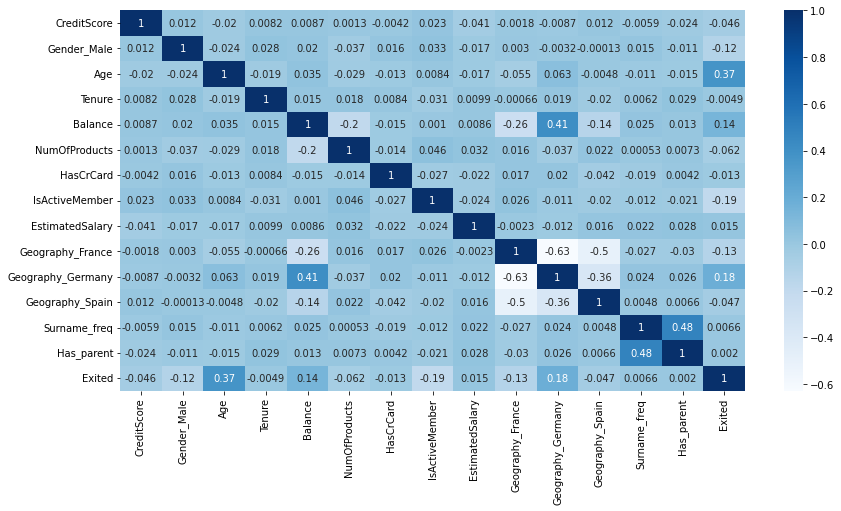

In [20]:
fig = plt.subplots(figsize=(14,7))

sns.heatmap(normalized_data.corr(), annot=True, cmap='Blues')
plt.show()

#### Correlation of each variable with the target variable

In [21]:
normalized_data.corr()['Exited'].sort_values().to_frame()

,Exited
IsActiveMember,-0.191917
Geography_France,-0.132148
Gender_Male,-0.122945
NumOfProducts,-0.062051
Geography_Spain,-0.047082
CreditScore,-0.046223
HasCrCard,-0.012533
Tenure,-0.004927
Has_parent,0.001965
Surname_freq,0.006638


Através da análise das correlações acima, é possivel criar algumas hipóteses. Abaixo estão listados os 05 fatores mais determinantes para a saída de um cliente:
1. **Idade:** quanto mais velho é o cliente, maior a chance de ele sair.
2. **Atividade:** a chance de alguém sair é maior quando este não é ativo
3. **Nacionalidade:** alemães possuem a maior chance de sair, espanhóis possuem chance menor e franceses menor ainda. 
4. **Saldo:** clientes com maiores saldos tendem a sair
5. **Gênero:** clientes do gênero masculino tem menores chance de saída quando comparado com o gênero feminino.

In [22]:
normalized_data.drop(columns={'Has_parent', 'Tenure'}, inplace=True)

#### Population parameters estimative

Como mencionado acima, fatores importantes para análise são Idade, Atividade, Nacionalidade, Saldo e Gênero. Por essa razão, logo abaixo tais parâmetros serão estimados para a população (todos os clientes da empresa) em que a amostra faz parte. Isso será feito como tentativa de entender melhor o perfil desses clientes que abandonam a empresa.

In [23]:
data['CreditScore'].describe()

count    4075.000000
mean      650.011779
std        97.889601
min       379.500000
25%       582.000000
50%       651.000000
75%       717.000000
max       850.000000
Name: CreditScore, dtype: float64

<AxesSubplot:ylabel='Frequency'>

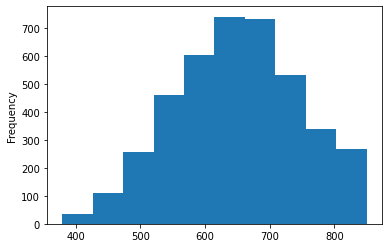

In [24]:
data['CreditScore'].plot(kind='hist')

In [25]:
# Age estimative
u_hat = data.query('Exited == 1')['Age'].mean()
sigma_hat = data.query('Exited == 1')['Age'].std()
n_sample = data.query('Exited == 1')['Age'].count()
error = estimate_error_for_mean(mean=u_hat, std=sigma_hat, n=n_sample, confidence=0.95)

print('- A idade média dos clientes que saem está entre %d e %d anos' % (u_hat-error, u_hat+error))

- A idade média dos clientes que saem está entre 44 e 45 anos


In [26]:
# Balance estimative
u_hat = data.query('Exited == 1')['Balance'].mean()
sigma_hat = data.query('Exited == 1')['Balance'].std()
n_sample = data.query('Exited == 1')['Balance'].count()
error = estimate_error_for_mean(mean=u_hat, std=sigma_hat, n=n_sample, confidence=0.95)

print('- O saldo médio mensal dos clientes que saem está entre %.2f e %.2f dólares' % ((u_hat-error)/12, (u_hat+error)/12))

- O saldo médio mensal dos clientes que saem está entre 7381.18 e 7803.58 dólares


In [27]:
# Active proportion estimative
p_hat = 1 - data.query('IsActiveMember == 1')['Exited'].mean()
n_sample = data.query('IsActiveMember == 1')['Exited'].count()
error = estimate_error_for_proportion(proportion=p_hat, n=n_sample, confidence=0.95)

print('- A probabilidade de um cliente ativo não sair é de %.2f%% a %.2f%%' % (100*(p_hat-error), 100*(p_hat+error)))

- A probabilidade de um cliente ativo não sair é de 58.26% a 62.71%


In [28]:
# Gender proportion estimative
p_hat = 1 - data.query('Gender_Male == 1')['Exited'].mean()
n_sample = data.query('Gender_Male == 1')['Exited'].count()
error = estimate_error_for_proportion(proportion=p_hat, n=n_sample, confidence=0.95)

print('- A probabilidade de um cliente masculino não sair é de %.2f%% a %.2f%%' % (100*(p_hat-error), 100*(p_hat+error)))

- A probabilidade de um cliente masculino não sair é de 53.98% a 58.28%


In [29]:
# Germany geo proportion estimative
p_hat = data.query('Geography_Germany == 1')['Exited'].mean()
n_sample = data.query('Geography_Germany == 1')['Exited'].count()
error = estimate_error_for_proportion(proportion=p_hat, n=n_sample, confidence=0.95)

print('- A probabilidade de um cliente alemão sair é de %.2f%% a %.2f%%' % (100*(p_hat-error), 100*(p_hat+error)))

- A probabilidade de um cliente alemão sair é de 60.96% a 66.23%


In [30]:
# France geo proportion estimative
p_hat = data.query('Geography_France == 1')['Exited'].mean()
n_sample = data.query('Geography_France == 1')['Exited'].count()
error = estimate_error_for_proportion(proportion=p_hat, n=n_sample, confidence=0.95)

print('- A probabilidade de um cliente francês sair é de %.2f%% a %.2f%%' % (100*(p_hat-error), 100*(p_hat+error)))

- A probabilidade de um cliente francês sair é de 40.65% a 45.11%


In [31]:
# Spain Geo proportion estimative
p_hat = data.query('Geography_Spain == 1')['Exited'].mean()
n_sample = data.query('Geography_Spain == 1')['Exited'].count()
error = estimate_error_for_proportion(proportion=p_hat, n=n_sample, confidence=0.95)

print('- A probabilidade de um cliente espanhol sair é de %.2f%% a %.2f%%' % (100*(p_hat-error), 100*(p_hat+error)))

- A probabilidade de um cliente espanhol sair é de 42.34% a 48.83%


In [32]:
# Exited proportion estimative
original_data = pd.read_csv('../Dataset/churn-modelling.zip')['Exited']

p_hat = original_data.mean()
n_sample = original_data.count()

#Maximo erro possível de proporção - caso a amostra não seja muito representativa na realidade
error = 2.33 * 1 / (2*sqrt(n))

print('- A probabilidade de um cliente sair é de %.2f%% a %.2f%%' % (100*(p_hat-error), 100*(p_hat+error)))

- A probabilidade de um cliente sair é de 17.79% a 22.95%


### Modeling

In [33]:
X, y = normalized_data.drop('Exited', axis=1), normalized_data['Exited']

kf = KFold(n_splits=5)

rights = [] #rights list
rights_positive = [] #positive rights list
rights_negative = [] #negative rights list
cms = [] #confusion matrix list
rocs = [] #AUC ROC list

for train_index, test_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    model = RandomForestClassifier(random_state=7)
    model.fit(X_train, y_train)
    
    y_hat = model.predict(X_test)

    cm = confusion_matrix(y_true=y_test, y_pred=y_hat)
    cms.append(cm)
    
    right = (cm[1][1] + cm[0][0]) / (cm[1][0] + cm[1][1] + cm[0][0] + cm[0][1])
    rights.append(right)
    
    right_positive_rate = cm[1][1] / (cm[1][0] + cm[1][1])
    rights_positive.append(right_positive_rate)
    
    right_negative_rate = cm[0][0] / (cm[0][0] + cm[0][1])
    rights_negative.append(right_negative_rate)
    
    roc = roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:, 1]) 
    rocs.append(roc)
    
rights = np.array(rights)    
rights_positive = np.array(rights_positive)
rights_negative = np.array(rights_negative)
rocs = np.array(rocs)


model.fit(X, y)

RandomForestClassifier(random_state=7)

Para criação do modelo preditivo foi utilizado o algoritmo de classificação com Floresta Aleatória. O modo de treinamento foi feito com validação cruzada de 5 dobras usando o conjunto de dados normalizado obtido com o pré processamento feito nesse arquivo. 

Para cada teste feito pela validação cruzada, a taxa de acertos com relação a casos positivos e a taxa de acertos com relação a negativos foram armazenadas, assim como a área sobre a curva ROC de cada teste.

A avaliação do desempenho geral do modelo a partir do conjunto de dados utilizado pode ser encontrada no próximo tópico.



## Evaluation

#### Rights vs Erros

In [34]:
mean = rights.mean()
std = rights.std()

print('Para diferentes grupos de 100 pessoas cada analisados, o modelo acertou cerca de %d a %d (média %2.f%%).' % (100*(mean-std), 100*(mean+std), 100*mean))

Para diferentes grupos de 100 pessoas cada analisados, o modelo acertou cerca de 75 a 79 (média 77%).


#### Positive rights rate

In [35]:
mean = rights_positive.mean()
std = rights_positive.std()

print('Para diferentes grupos de 100 pessoas cada analisados que saíram (porém o modelo desconhecia essa informação),\nele acertou cerca de %d a %d (média %2.f%%).' % (100*(mean-std), 100*(mean+std), 100*mean))
print('Portanto, a ocorrência de falso negativo foi de %d%% a %d%% (média %2.f%%).' % (100 - 100*(mean+std), 100 - 100*(mean-std), 100 - 100*mean))

Para diferentes grupos de 100 pessoas cada analisados que saíram (porém o modelo desconhecia essa informação),
ele acertou cerca de 74 a 77 (média 76%).
Portanto, a ocorrência de falso negativo foi de 22% a 25% (média 24%).


#### Negative right rate

In [36]:
mean = rights_negative.mean()
std = rights_negative.std()

print('Para diferentes grupos de 100 pessoas cada analisados que não saíram (porém o modelo desconhecia essa informação), ele acertou cerca de %d a %d (média %2.f%%).' % (100*(mean-std), 100*(mean+std), 100*mean))
print('Portanto, a ocorrência de falso positivo foi de %d%% a %d%% (média %2.f%%).' % (100 - 100*(mean+std), 100 - 100*(mean-std), 100-100*mean))

Para diferentes grupos de 100 pessoas cada analisados que não saíram (porém o modelo desconhecia essa informação), ele acertou cerca de 75 a 81 (média 78%).
Portanto, a ocorrência de falso positivo foi de 18% a 24% (média 22%).


### Estimated evaluation for after deploy the solution

Estimativas feitas com intervalo de confiança de 98%.

In [37]:
n = X.shape[0]//5
print('Número de pessoas testadas em cada grupo: ', n)

Número de pessoas testadas em cada grupo:  815


In [38]:
mean = rights.mean()
std = rights.std() 
error = estimate_error_for_proportion(proportion=mean, n=n, confidence=0.98)

print('A cada 100 pessoas, estima-se que o modelo acertará cerca de %d a %d.' % (100*(mean-std-error), 100*(mean+std+error)))

A cada 100 pessoas, estima-se que o modelo acertará cerca de 72 a 82.


In [39]:
mean = rights_positive.mean()
std = rights_positive.std()
error = estimate_error_for_proportion(proportion=mean, n=n, confidence=0.98)

print('A cada 100 pessoas que realmente sairiam, estima-se que o modelo acertará cerca de %d a %d.' % (100*(mean-std-error), 100*(mean+std+error)))
print('Portanto, a ocorrência de falso negativo estimada é de %d%% a %d%% (média %2.f%%).' % (100 - 100*(mean+std+error), 100 - 100*(mean-std-error), 100 - 100*mean))

A cada 100 pessoas que realmente sairiam, estima-se que o modelo acertará cerca de 71 a 81.
Portanto, a ocorrência de falso negativo estimada é de 18% a 28% (média 24%).


In [40]:
mean = rights_negative.mean()
std = rights_negative.std()
error = estimate_error_for_proportion(proportion=mean, n=n, confidence=0.98)

print('A cada 100 pessoas que não sairiam, estima-se que o modelo acertará cerca de %d a %d.' % (100*(mean-std-error), 100*(mean+std+error)))
print('Portanto, a ocorrência de falso positivo estimada é de %d%% a %d%% (média %2.f%%).' % (100 - 100*(mean+std+error), 100 - 100*(mean-std-error), 100 - 100*mean))

A cada 100 pessoas que não sairiam, estima-se que o modelo acertará cerca de 72 a 84.
Portanto, a ocorrência de falso positivo estimada é de 15% a 27% (média 22%).


## Deploy

Neste arquivo contém apenas a primeira parte do processo de deploy da solução: o armazenamento do modelo utilizado e do normalizador utilizado para normalizar os dados.

### Saving results

In [41]:
X.columns

Index(['CreditScore', 'Gender_Male', 'Age', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Surname_freq'],
      dtype='object')

#### Scaler save

In [ ]:
scaler_file = open('../Scalers/min_max_quantitatives.pkl', 'wb')
pickle.dump(scaler, scaler_file)
scaler_file.close()

#### Model save

In [ ]:
model_file = open('../Models/class_model.pkl', 'wb')
pickle.dump(model, model_file)
model_file.close()